Run 1, Epoch 8, Loss: 0.1522, Gradient Norm: 1.8923
Run 2, Epoch 8, Loss: 0.1573, Gradient Norm: 1.8522
Run 3, Epoch 8, Loss: 0.1532, Gradient Norm: 1.8964
Run 4, Epoch 8, Loss: 0.1524, Gradient Norm: 1.8439
Run 5, Epoch 8, Loss: 0.1577, Gradient Norm: 1.8884
Run 6, Epoch 8, Loss: 0.1555, Gradient Norm: 1.8737
Run 7, Epoch 8, Loss: 0.1565, Gradient Norm: 1.8621
Run 8, Epoch 8, Loss: 0.1476, Gradient Norm: 1.8479


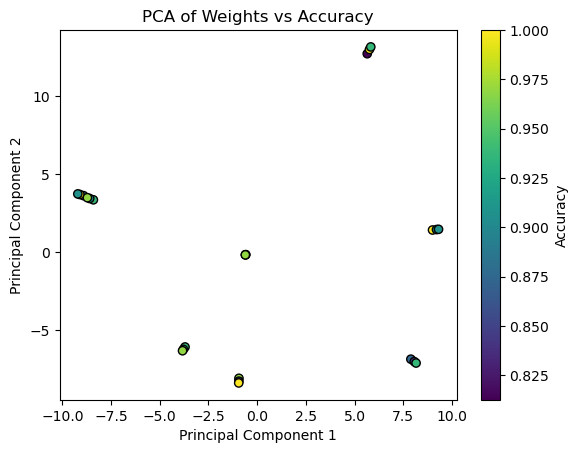

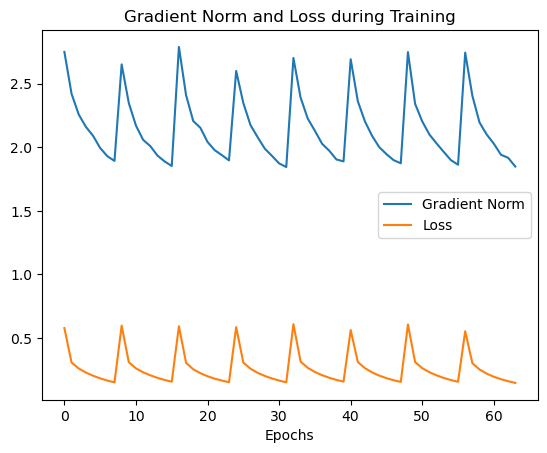

Mismatch in lengths of minimal_gradients and collected_losses


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple DNN Model
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the model
def train_model(epochs=8, collect_interval=3):
    model = SimpleDNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    weights_collection = []
    accuracy_collection = []
    losses = []
    gradients = []

    for run in range(8):  # Train 8 times
        model.apply(lambda m: torch.nn.init.xavier_uniform_(m.weight) if hasattr(m, 'weight') else None)
        for epoch in range(epochs):
            epoch_loss = 0
            gradient_norm = 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                
                # Forward pass
                output = model(data)
                loss = criterion(output, target)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient norm
                gradient_norm += sum(p.grad.norm().item() ** 2 for p in model.parameters() if p.grad is not None) ** 0.5
                
                optimizer.step()
                epoch_loss += loss.item()
            
            epoch_loss /= len(train_loader)
            gradient_norm /= len(train_loader)

            # Collect weights every 'collect_interval' epochs
            if epoch % collect_interval == 0:
                weights_collection.append(np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters()]))
                accuracy = (torch.argmax(output, dim=1) == target).float().mean().item()
                accuracy_collection.append(accuracy)
            
            losses.append(epoch_loss)
            gradients.append(gradient_norm)

        print(f"Run {run+1}, Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Gradient Norm: {gradient_norm:.4f}")

    return weights_collection, accuracy_collection, losses, gradients

# PCA Dimensionality Reduction and Plotting
def plot_pca_weights(weights_collection, accuracy_collection):
    weights = np.array(weights_collection)
    pca = PCA(n_components=2)
    reduced_weights = pca.fit_transform(weights)
    
    plt.figure()
    plt.scatter(reduced_weights[:, 0], reduced_weights[:, 1], c=accuracy_collection, cmap='viridis', edgecolor='k')
    plt.colorbar(label='Accuracy')
    plt.title('PCA of Weights vs Accuracy')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Plot Gradient Norm and Loss
def plot_gradient_loss(gradients, losses):
    plt.figure()
    plt.plot(gradients, label='Gradient Norm')
    plt.plot(losses, label='Loss')
    plt.title('Gradient Norm and Loss during Training')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

def plot_minimal_ratio(weights_collection, losses):
    # Ensure the losses are synchronized with weights_collection
    collected_losses = losses[::3]  # Assuming weights are collected every 3 epochs
    minimal_gradients = [np.linalg.norm(w) for w in weights_collection]
    
    if len(minimal_gradients) != len(collected_losses):
        print("Mismatch in lengths of minimal_gradients and collected_losses")
        return

    # Plot
    plt.figure()
    plt.scatter(minimal_gradients, collected_losses, c='red', edgecolor='k')
    plt.title('Minimal Ratio of Weights vs Loss')
    plt.xlabel('Minimal Ratio (Weight Norm)')
    plt.ylabel('Loss')
    plt.show()

# Main Execution
weights, accuracies, losses, gradients = train_model(epochs=8, collect_interval=3)
plot_pca_weights(weights, accuracies)
plot_gradient_loss(gradients, losses)
plot_minimal_ratio(weights, losses)
